# Sentiment Analysis using static dataset and Twitter data using Python

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nrclex import NRCLex

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shalinishah27/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shalinishah27/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shalinishah27/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [179]:
# Load the dataset
df = pd.read_csv('covid19_tweets.csv')

In [180]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [181]:
df.tail()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False
179107,TUKY II,"Aliwal North, South Africa",TOKELO SEKHOPA | TUKY II | LAST BORN | EISH TU...,2018-04-14 17:30:07,97,1697,566,False,2020-08-29 19:44:08,I stop when I see a Stop\n\n@SABCNews\n@Izinda...,NaN,Twitter for Android,False


In [182]:
df.all()

user_name            True
user_location        True
user_description     True
user_created         True
user_followers      False
user_friends        False
user_favourites     False
user_verified       False
date                 True
text                 True
hashtags             True
source               True
is_retweet          False
dtype: bool

In [183]:
print(df.columns)

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')


In [184]:
# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Data Cleaning Function
def clean_tweet(tweet):
    # Check if tweet is not a string (NaN or float)
    if not isinstance(tweet, str):
        return ''
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Define function to remove emojis
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    # Remove emojis
    tweet = remove_emoji(tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Remove punctuation and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove extra whitespace
    tweet = tweet.strip()
    tweet = re.sub(r'\s+', ' ', tweet)
    
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Reconstruct the cleaned tweet
    cleaned_tweet = ' '.join(cleaned_tokens)
    
    return cleaned_tweet

# Example usage with a dataset
df = pd.read_csv('covid19_tweets.csv')

# Assuming 'user_description' is the column you want to clean
df['cleaned_tweet'] = df['user_description'].apply(clean_tweet)

# Display the cleaned tweets
print(df[['user_description', 'cleaned_tweet']].head())
print(df[['user_description', 'cleaned_tweet']].tail())

                                    user_description  \
0  wednesday addams as a disney princess keepin i...   
1  Husband, Father, Columnist & Commentator. Auth...   
2  #Christian #Catholic #Conservative #Reagan #Re...   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...   
4  🖊️Official Twitter handle of Department of Inf...   

                                       cleaned_tweet  
0            wednesday addams disney princess keepin  
1  husband father columnist commentator author to...  
2  christian catholic conservative reagan republi...  
3            brown indian clevelandproud cavs resist  
4  official twitter handle department information...  
                                         user_description  \
179103    Animal Scientist|| Muslim|| Real Madrid/Chelsea   
179104  When your cat has more baking soda than Ninja ...   
179105  ⚒️ The Architects of Free Trade ⚒️ Really Did ...   
179106  Global UX UI Visual Designer. StoryTeller, Mus...   
179107  TOKELO SEKHOPA | TUK

In [185]:
# Define a function to get sentiment
#def get_sentiment(tweet):
    #score = analyzer.polarity_scores(tweet)
    #return 'positive' if score['compound'] > 0 else 'negative' if score['compound'] < 0 else 'neutral'

# Apply sentiment analysis to 'cleaned_tweet' column
#df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment)

# Sentiment Detection Function
analyzer = SentimentIntensityAnalyzer()

def detect_sentiment(tweet):
    if not isinstance(tweet, str) or tweet == '':
        return 'neutral'
    scores = analyzer.polarity_scores(tweet)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['cleaned_tweet'].apply(detect_sentiment)

In [186]:
# Emotion Detection
# Placeholder for emotion detection logic
#def detect_emotion(tweet):
    # Implement emotion detection here
    #return 'joy'

#df['emotion'] = df['cleaned_tweet'].apply(detect_emotion)

# Emotion Detection Function
def detect_emotion(tweet):
    if not isinstance(tweet, str) or tweet == '':
        return 'neutral'
    emotion_analyzer = NRCLex(tweet)
    if emotion_analyzer.top_emotions:
        emotion = emotion_analyzer.top_emotions[0][0]
    else:
        emotion = 'neutral'
    return emotion

df['emotion'] = df['cleaned_tweet'].apply(detect_emotion)

In [187]:
# Display the cleaned tweets and their detected emotions
print(df[['text', 'cleaned_tweet', 'emotion']].head())
print(df[['text', 'cleaned_tweet', 'emotion']].tail())

                                                text  \
0  If I smelled the scent of hand sanitizers toda...   
1  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  @brookbanktv The one gift #COVID19 has give me...   
4  25 July : Media Bulletin on Novel #CoronaVirus...   

                                       cleaned_tweet   emotion  
0            wednesday addams disney princess keepin  positive  
1  husband father columnist commentator author to...     trust  
2  christian catholic conservative reagan republi...  positive  
3            brown indian clevelandproud cavs resist  negative  
4  official twitter handle department information...  positive  
                                                     text  \
179103  Thanks @IamOhmai for nominating me for the @WH...   
179104  2020! The year of insanity! Lol! #COVID19 http...   
179105  @CTVNews A powerful painting by Juan Lucena. I...   
179106  More than 1,200 stude

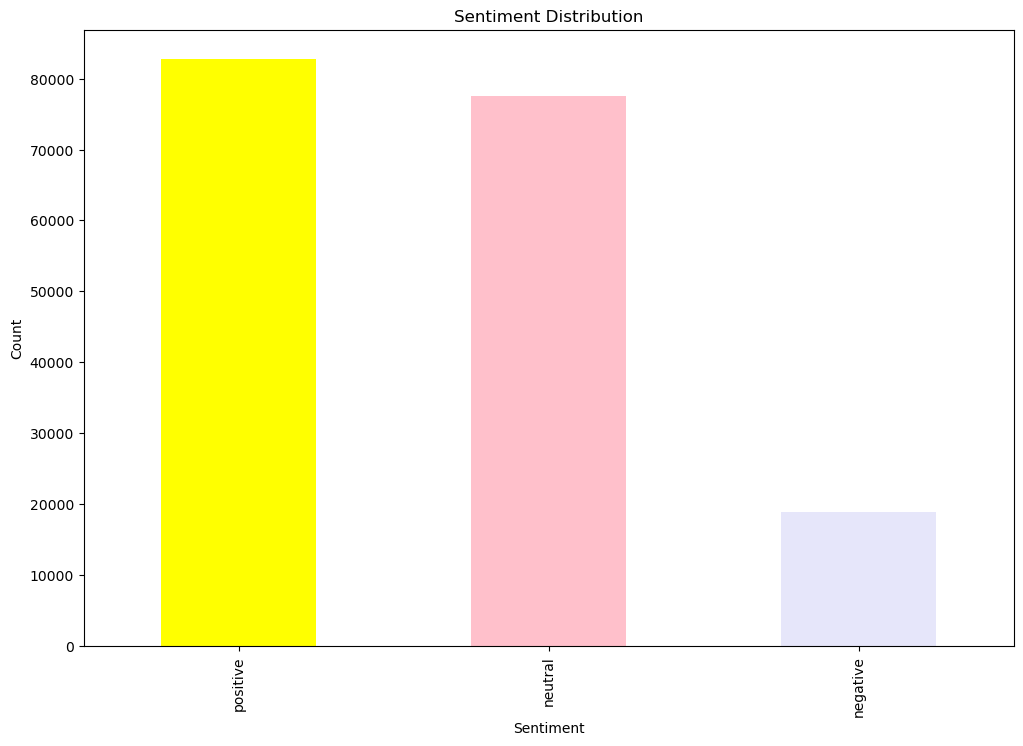

In [188]:
# Visualize Sentiment Distribution
plt.figure(figsize=(12,8))
df['sentiment'].value_counts().plot(kind='bar', color=['yellow', 'pink', 'lavender'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

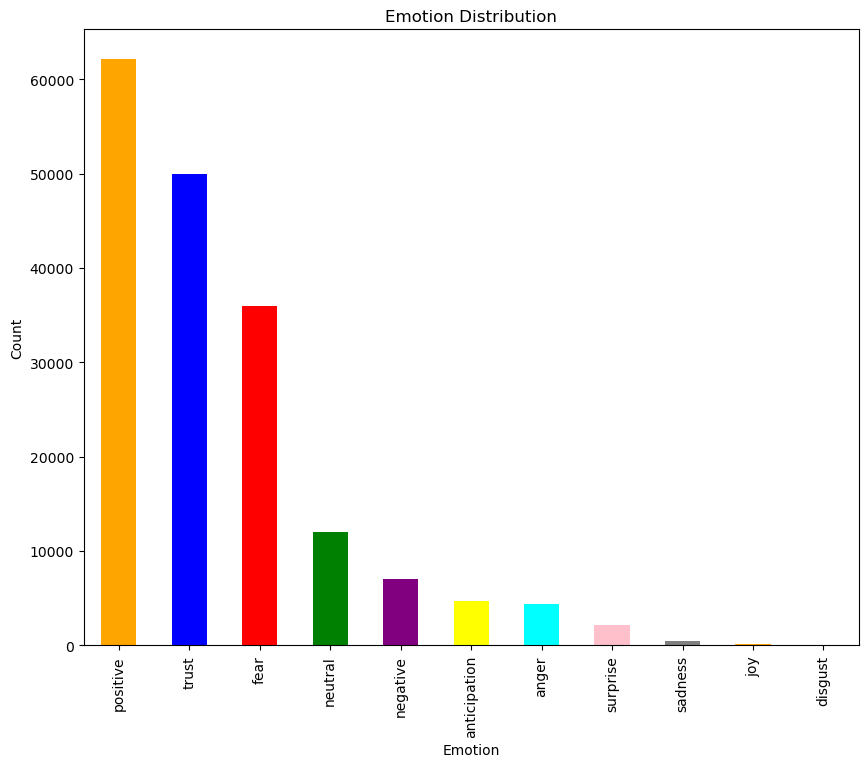

In [189]:
# Visualize Emotion Distribution
plt.figure(figsize=(10,8))
df['emotion'].value_counts().plot(kind='bar', color=['orange', 'blue', 'red', 'green', 'purple','yellow','cyan','pink','grey'])
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

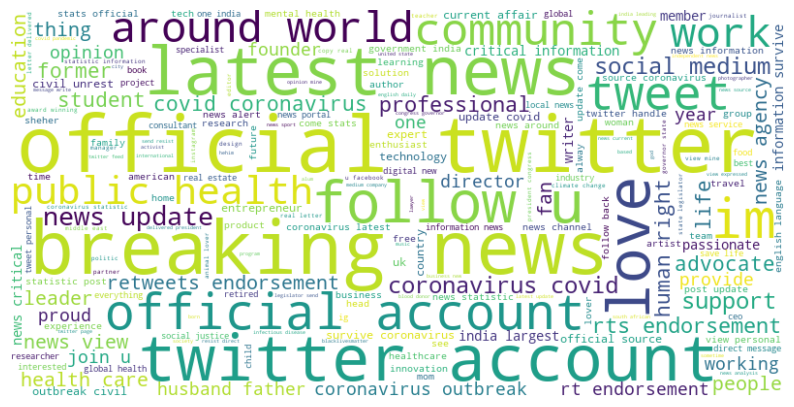

In [190]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_tweet']))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

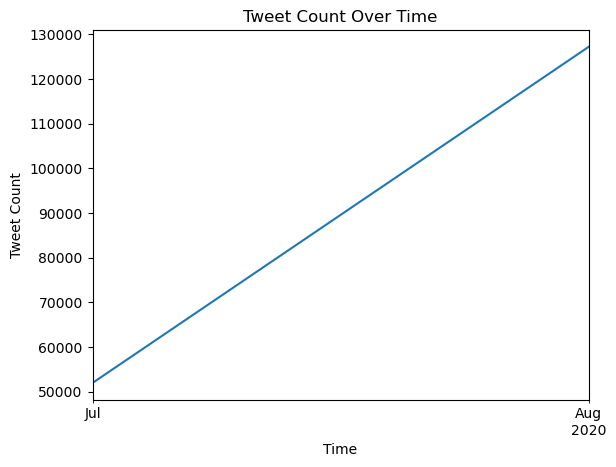

In [191]:
# Trends Over Time
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.resample('M').size().plot()
plt.title('Tweet Count Over Time')
plt.xlabel('Time')
plt.ylabel('Tweet Count')
plt.show()

In [192]:
print(df['sentiment'].value_counts())
print(df['user_location'].value_counts())
print(df['emotion'].value_counts())

positive    82743
neutral     77492
negative    18873
Name: sentiment, dtype: int64
India                         3741
United States                 2455
New Delhi, India              1721
Mumbai, India                 1401
Washington, DC                1354
                              ... 
Crystal Lake, IL                 1
Johnstown, PA                    1
A little east of LAX...          1
#Ireland                         1
Aliwal North, South Africa       1
Name: user_location, Length: 26920, dtype: int64
positive        62178
trust           50001
fear            35987
neutral         12027
negative         7037
anticipation     4740
anger            4346
surprise         2141
sadness           498
joy               110
disgust            43
Name: emotion, dtype: int64


In [193]:
# Example DataFrame (replace with your cleaned DataFrame)
df = pd.DataFrame({
    'sentiment': ['positive', 'negative', 'neutral', ...],
    'location': ['India', 'Crystal Lake, IL', 'Mumbai, India', ...],
    'emotion': ['sadness', 'trust', 'disgust', ...]
})

In [194]:
print(df.columns)

Index(['sentiment', 'location', 'emotion'], dtype='object')


<Figure size 1000x600 with 0 Axes>

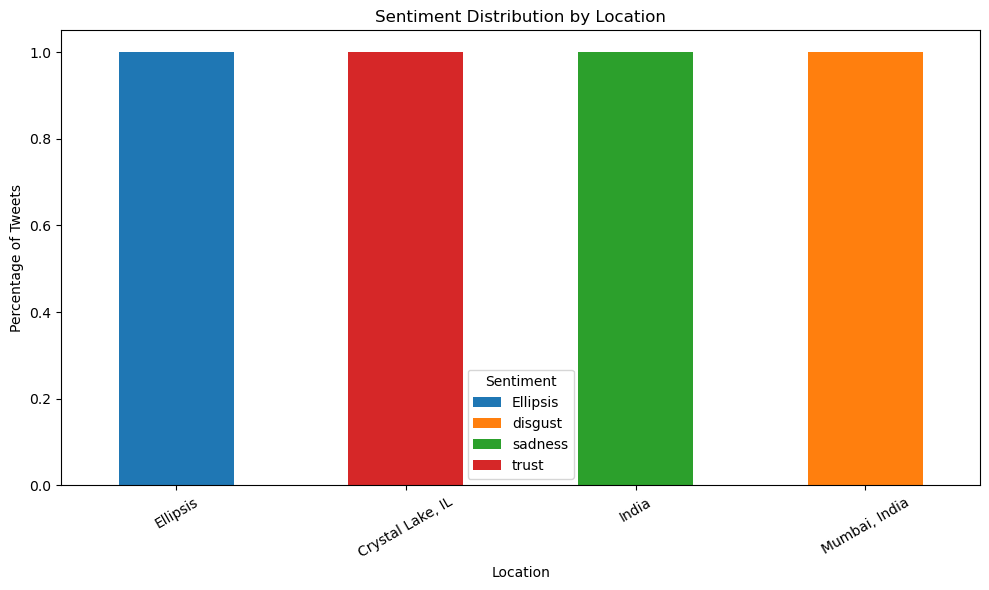

In [195]:
# Visualize Sentiment Distribution by Location
plt.figure(figsize=(10, 6))
location_sentiment = df.groupby('location')['emotion'].value_counts(normalize=True).unstack().fillna(0)
location_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Percentage of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()